**Segmentation based on morphogenie**

http://morphogenie.fr/segmenting-nuclei.html

In [17]:
import skimage.io as io
io.use_plugin('tifffile')

#I updated "skimage.filter" to the more recent plural "skimage.filters"
from skimage.filters import threshold_otsu, threshold_adaptive, rank
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage.morphology import disk, watershed
import pandas as pd
import numpy as np #added to morphogenie code
import mahotas as mh  #Don't know if this is used?
import matplotlib.pyplot as plt #added to morphogenie code

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier
from scipy import fftpack
from matplotlib.colors import LogNorm

In [2]:
!pip install plotly

  Running setup.py bdist_wheel for plotly: started
  Running setup.py bdist_wheel for plotly: still running...
  Running setup.py bdist_wheel for plotly: still running...
  Running setup.py bdist_wheel for plotly: still running...
  Running setup.py bdist_wheel for plotly: still running...
  Running setup.py bdist_wheel for plotly: finished with status 'done'
  Stored in directory: C:\Users\David Brown\AppData\Local\pip\Cache\wheels\9f\8c\a4\a1a26a9a0ac42d852e0fb4b0ba021cc6b881aab075d03e903b
  Running setup.py bdist_wheel for retrying: started
  Running setup.py bdist_wheel for retrying: finished with status 'done'
  Stored in directory: C:\Users\David Brown\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built plotly retrying
  Found existing installation: nbformat 4.1.0


Cannot uninstall 'nbformat'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [13]:
#I adjusted the morphogenie code to import the full stack, and then focus on the Hoechst Channel for segmentation.
im = io.imread('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_2_Box1.tif')

image_stack = im[:,:,:,0]

z_size, x_size, y_size = image_stack.shape

z_scale = 0.26 # µm per plane for 100x NIC confocal images
xy_scale = 0.065 # µm per pixel for 100x NIC confocal images

**Look at the stack**

In [15]:
%matplotlib inline

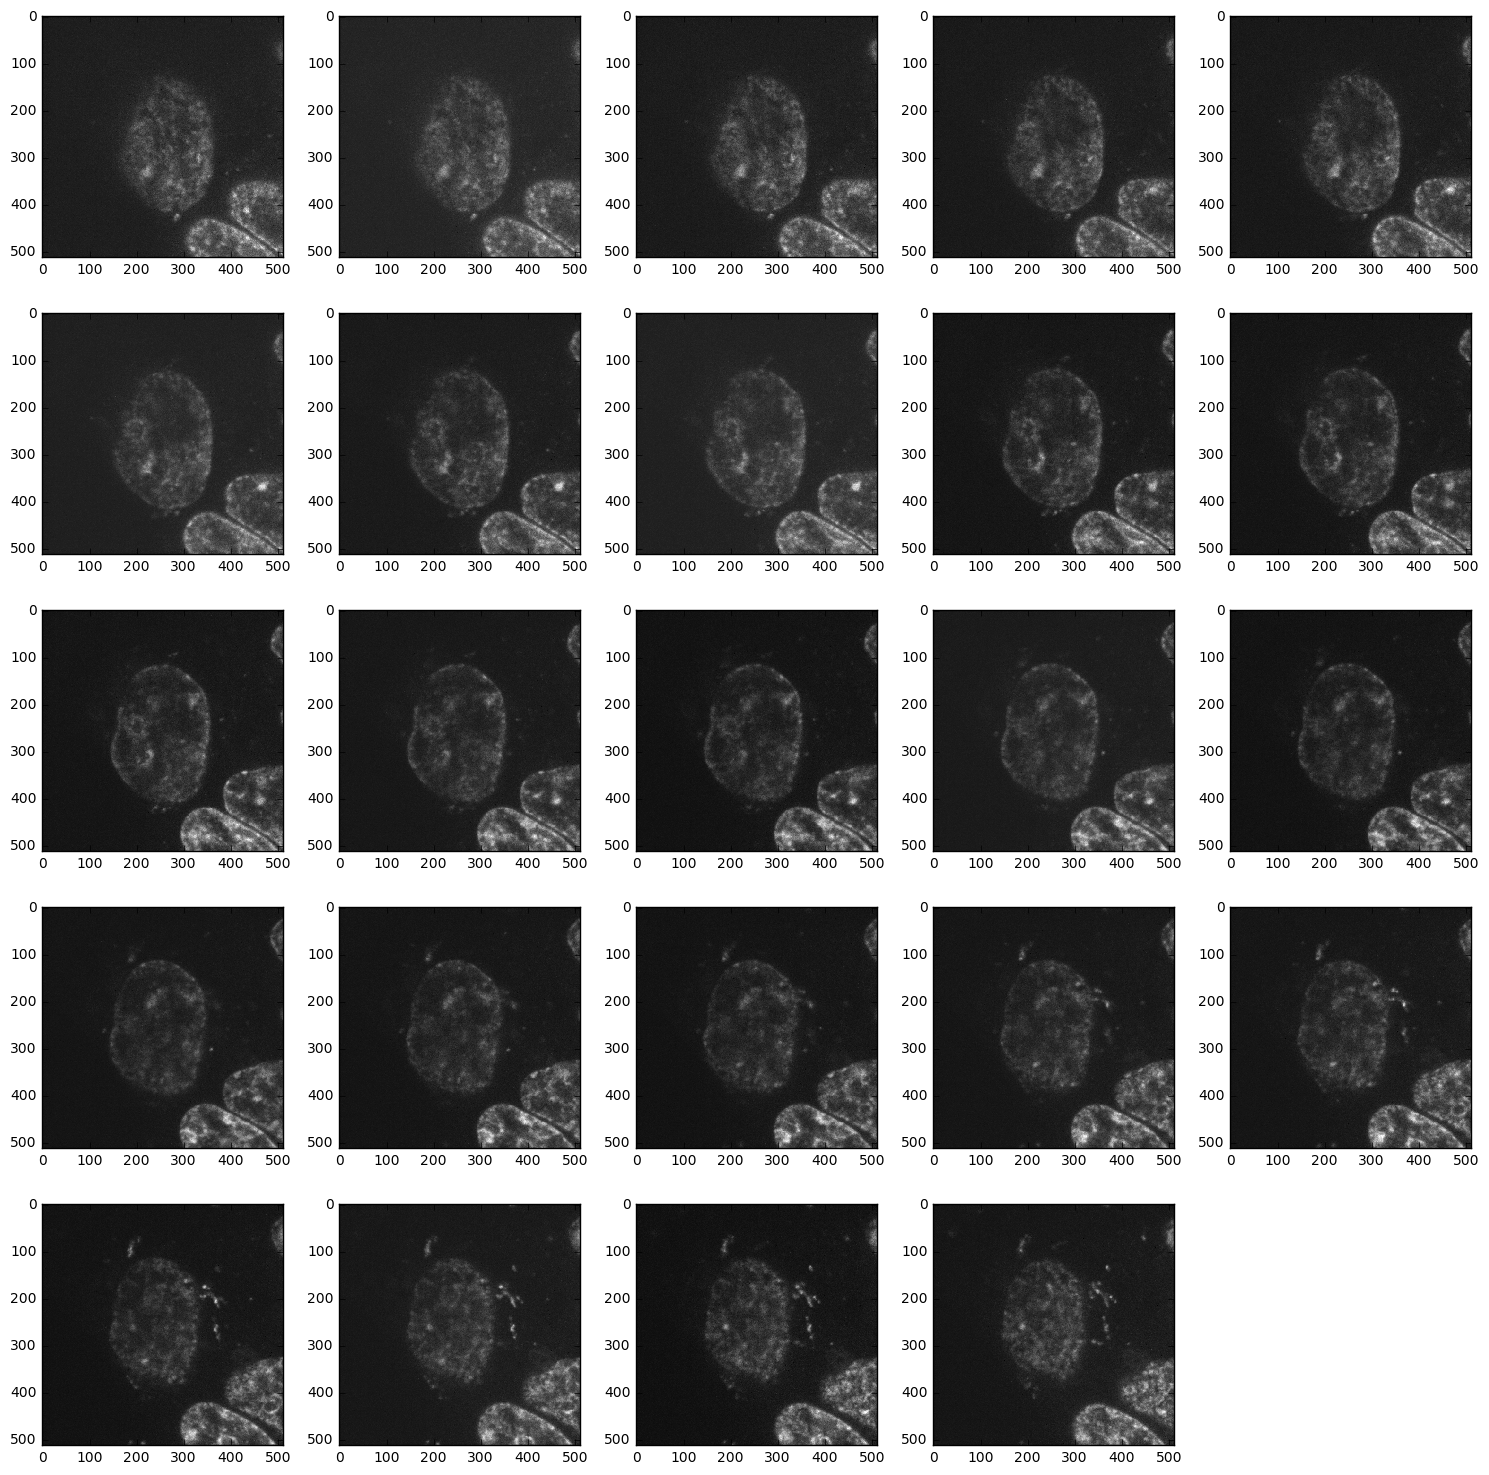

In [4]:
nrows = np.int(np.ceil(np.sqrt(z_size)))
ncols = np.int(z_size // nrows + 1)

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
for n in range(z_size):
    i = n // ncols
    j = n % ncols
    axes[i, j].imshow(image_stack[n, ...],
                      interpolation='nearest', cmap='gray')
    
    
## Remove empty plots 
for ax in axes.ravel():
    if not(len(ax.images)):
        fig.delaxes(ax)
fig.tight_layout()

**Plot Histogram**

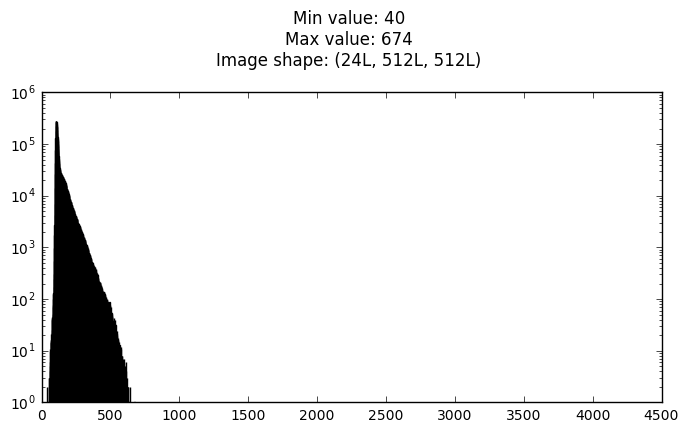

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(image_stack.flatten(), log=True,
        bins=4096, range=(0, 4096))

_ = ax.set_title('Min value: %i \n'
                 'Max value: %i \n'
                 'Image shape: %s \n'
                 % (image_stack.min(),
                    image_stack.max(),
                    image_stack.shape))

In [33]:
smoothed_stack = np.zeros_like(image_stack)
labeled_stack = smoothed_stack.copy()

## Labeling for each z plane:
for z, frame in enumerate(image_stack):
    smoothed = mh.gaussian_filter(frame, 8.)
    smoothed_stack[z] = smoothed
    T_mean = smoothed.mean()
    bin_image = smoothed > T_mean
    labeled, nr_objects = mh.label(bin_image)
    #print(nr_objects)
    labeled_stack[z] = labeled

In [34]:
#Check
#for z, frame in enumerate(image_stack):
#    print(z, frame)

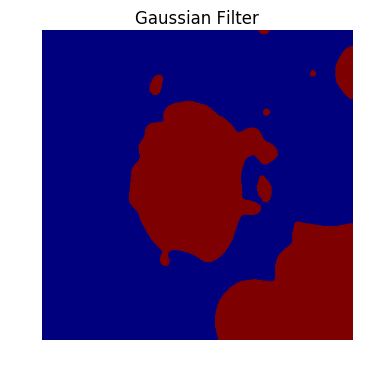

In [35]:
##Check a single z
plt.imshow(bin_image)
plt.axis('off')
plt.title('Gaussian Filter')

**Plot Gaussian Filter Results**

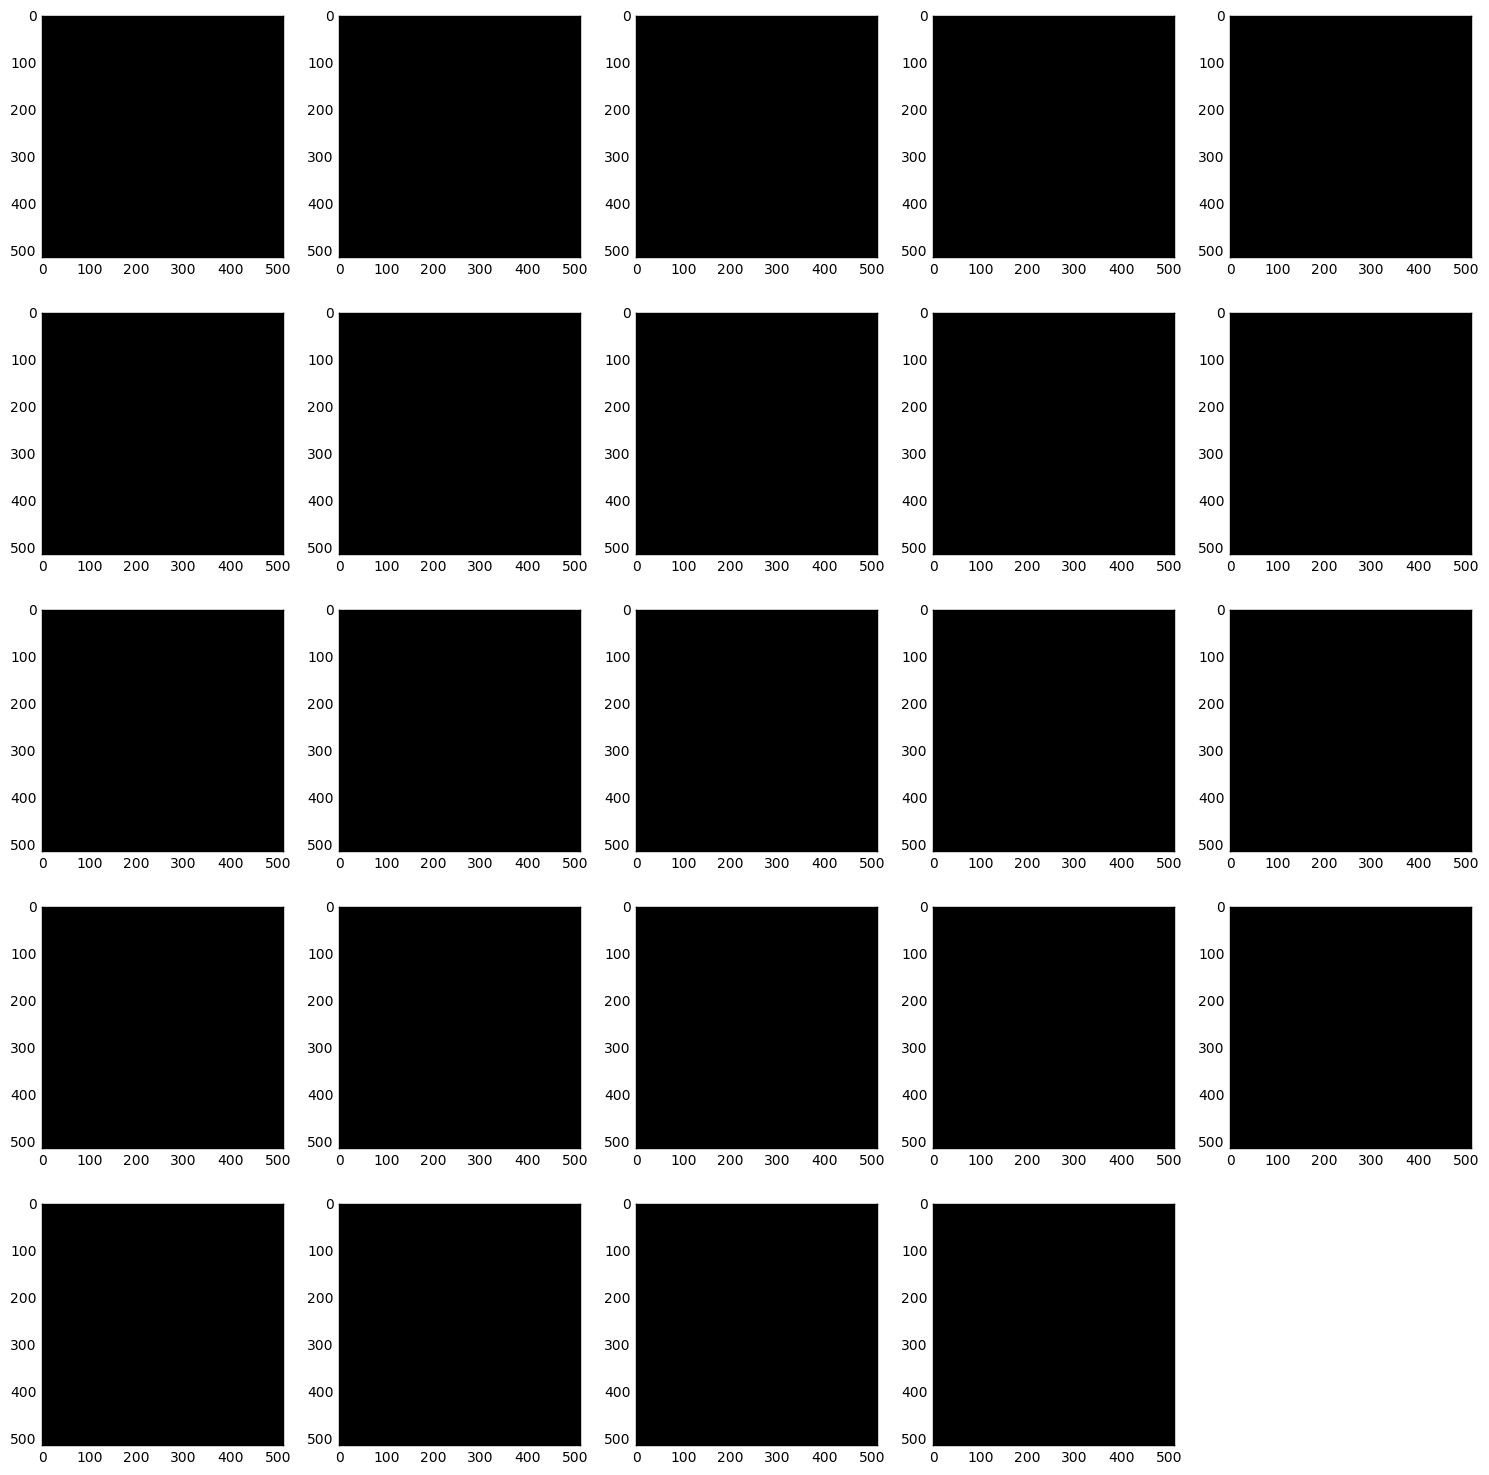

In [79]:
##Check the filtered stack
nrows = np.int(np.ceil(np.sqrt(z_size)))
ncols = np.int(z_size // nrows + 1)

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
for n in range(z_size):
    i = n // ncols
    j = n % ncols
    axes[i, j].imshow(labeled_stack[n, ...],
                      interpolation='nearest', cmap='gray')
    
    
## Remove empty plots 
for ax in axes.ravel():
    if not(len(ax.images)):
        fig.delaxes(ax)
fig.tight_layout()

**Watershed**

In [62]:
#Runs suuuuuper slow
smoothed_stack = np.zeros_like(image_stack)
labeled_stack = smoothed_stack.copy()
local=4

## Labeling for each z plane:
for z, frame in enumerate(image_stack):
    smoothed = mh.gaussian_filter(frame, 8.)
    smoothed_stack[z] = smoothed
    T_mean = smoothed.mean()
    bin_image = smoothed > T_mean
  
    distance = ndimage.distance_transform_edt(bin_image)
    local_maxi = peak_local_max(distance, min_distance=2*local,
                                    indices=False, labels=smoothed) #this step may be the problem as min_radius is high.
    markers = ndimage.label(local_maxi)[0]
    labeled_stack[z] = watershed(-distance, markers, mask=bin_image)

KeyboardInterrupt: 

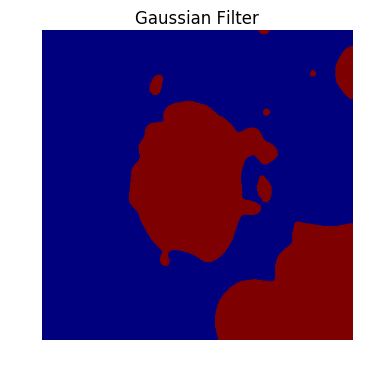

In [65]:
#Runs suuuuuper slow
ws = np.zeros_like(frame)
local=4

## Labeling for each z plane:
#for z, frame in enumerate(image_stack):
frame=im[23,:,:,0]#temporary
smoothed = mh.gaussian_filter(frame, 8.)
#smoothed_stack[z] = smoothed
T_mean = smoothed.mean()
bin_image = smoothed > T_mean
  
plt.imshow(bin_image)
plt.axis('off')
plt.title('Gaussian Filter')

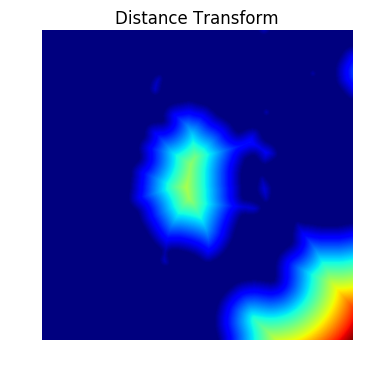

In [71]:
distance = ndimage.distance_transform_edt(bin_image)
plt.imshow(distance)
plt.axis('off')
plt.title('Distance Transform')

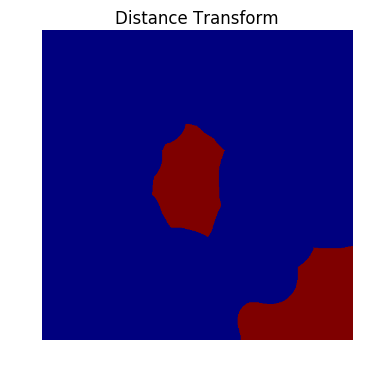

In [78]:
##Can you just threshold the distance map?
D_mean = distance.mean()
td_image = distance > D_mean+distance.std()
    
plt.imshow(td_image)
plt.axis('off')
plt.title('Distance Transform')

In [74]:
local=3
local_maxi = peak_local_max(distance, min_distance=2*local,
                                indices=False, labels=smoothed)     ##slow step!!

KeyboardInterrupt: 

In [ ]:
 #this step may be the problem as min_radius is high.
markers = ndimage.label(local_maxi)[0]
ws = watershed(-distance, markers, mask=bin_image)

plt.imshow(ws)
plt.axis('off')
plt.title('Watershed')

**Need to smooth result**

Try using a fast fourier transform band pass filter

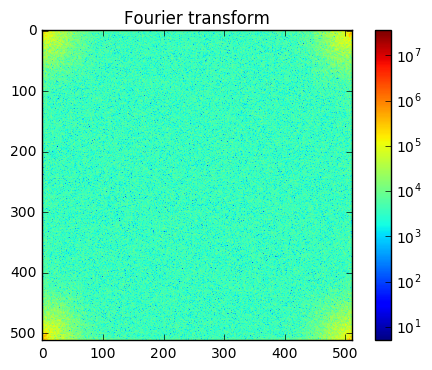

In [27]:
im_fft = fftpack.fft2(im[23,:,:,0])

# Show the results

def plot_spectrum(im_fft):
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

plt.figure()
plot_spectrum(im_fft)
plt.title('Fourier transform')

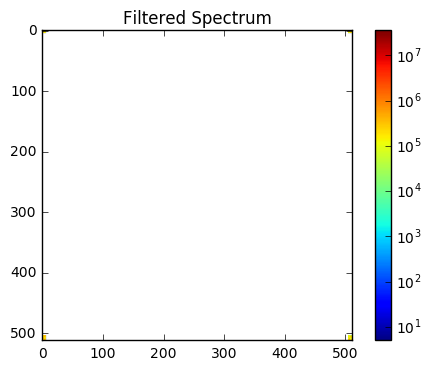

In [72]:
# In the lines following, we'll make a copy of the original spectrum and
# truncate coefficients.

# Define the fraction of coefficients (in each direction) we keep
keep_fraction = 0.015

# Call ff a copy of the original transform. Numpy arrays have a copy
# method for this purpose.
im_fft2 = im_fft.copy()

# Set r and c to be the number of rows and columns of the array.
r, c = im_fft2.shape

# Set to zero all rows with indices between r*keep_fraction and
# r*(1-keep_fraction):
im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0

# Similarly with the columns:
im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

plt.figure()
plot_spectrum(im_fft2)
plt.title('Filtered Spectrum')

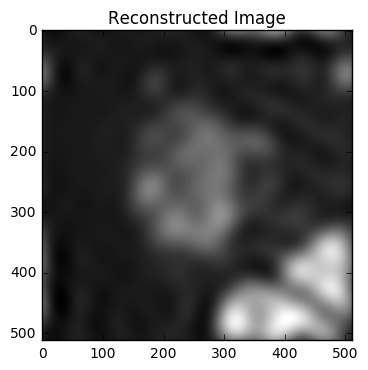

In [73]:
# Reconstruct the denoised image from the filtered spectrum, keep only the
# real part for display.
im_new = fftpack.ifft2(im_fft2).real

plt.figure()
plt.imshow(im_new, plt.cm.gray)
plt.title('Reconstructed Image')

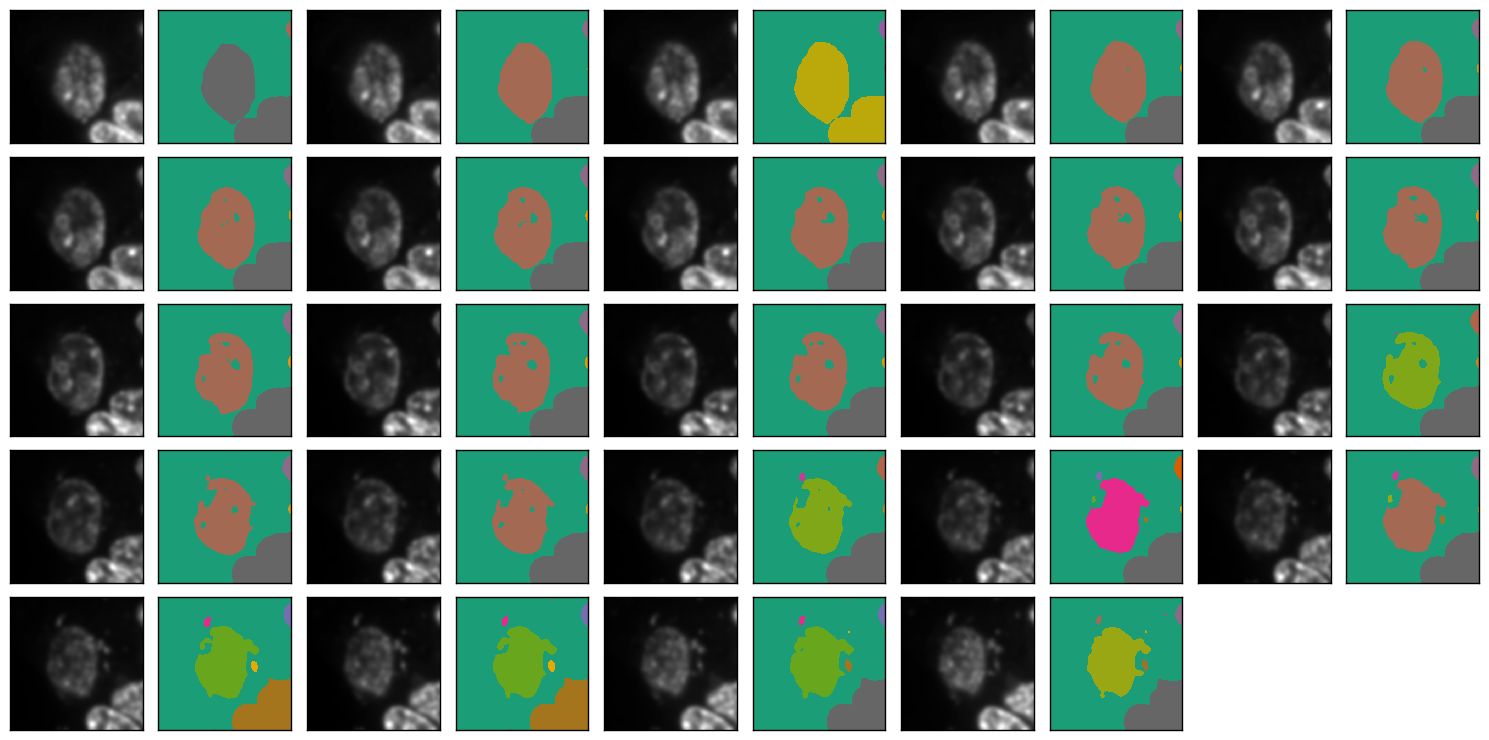

In [28]:
fig, axes = plt.subplots(nrows, ncols*2, figsize=(3*ncols, 1.5*nrows))

for z in range(z_size):
    i = z // ncols
    j = z % ncols * 2
    axes[i, j].imshow(smoothed_stack[z, ...], interpolation='nearest', cmap='gray')
    axes[i, j+1].imshow(labeled_stack[z, ...], interpolation='nearest', cmap='Dark2')
    
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    axes[i, j+1].set_xticks([])
    axes[i, j+1].set_yticks([])

## Remove empty plots 
for ax in axes.ravel():
    if not(len(ax.images)):
        fig.delaxes(ax)

        
fig.tight_layout()

**Detection parameters**

We usually need some settings, derived from what we now of the objects we are trying to segment. 
We’ll also normaly do some kind of smoothing, which will be specified as the pixel size of the filter kernel. So here we go:

In [52]:
smooth_sizesmooth_s  = 5 # pixels
min_radius = 50
max_radius = 500

**Computing the properties of the labeled regions:**

We use skimage.measure handy function regionprops. For convinience, we store the computed properties in a pandas DataFrame object (this is particullarly usefulll if you have more images or more timepoints, and want to later on manipulate the collected data.

In [53]:
properties = []
columns = ('x', 'y', 'z', 'I', 'w')
indices = []
for z, frame in enumerate(labeled_stack):
    f_prop = regionprops(frame.astype(np.int),
                         intensity_image=image_stack[z])
    for d in f_prop:
        radius = (d.area / np.pi)**0.5
        if (min_radius  < radius < max_radius):
            properties.append([d.weighted_centroid[0],
                               d.weighted_centroid[1],
                               z, d.mean_intensity * d.area,
                               radius])
            indices.append(d.label)
if not len(indices):
    all_props = pd.DataFrame([], index=[])
indices = pd.Index(indices, name='label')
properties = pd.DataFrame(properties, index=indices, columns=columns)
#properties['I'] /= properties['I'].max() #This will normalise the intensities to the brightest.

In [54]:
properties.head()

,x,y,z,I,w
label,,,,,
2,352.814860,338.124064,0,13186175.0,157.147815
2,283.082815,272.354797,1,7545438.0,123.983148
4,438.644705,419.420664,1,5810739.0,98.960204
2,349.770281,335.394319,2,13587448.0,159.742387
2,280.555266,269.790499,3,7847037.0,126.094794


**Clustering**

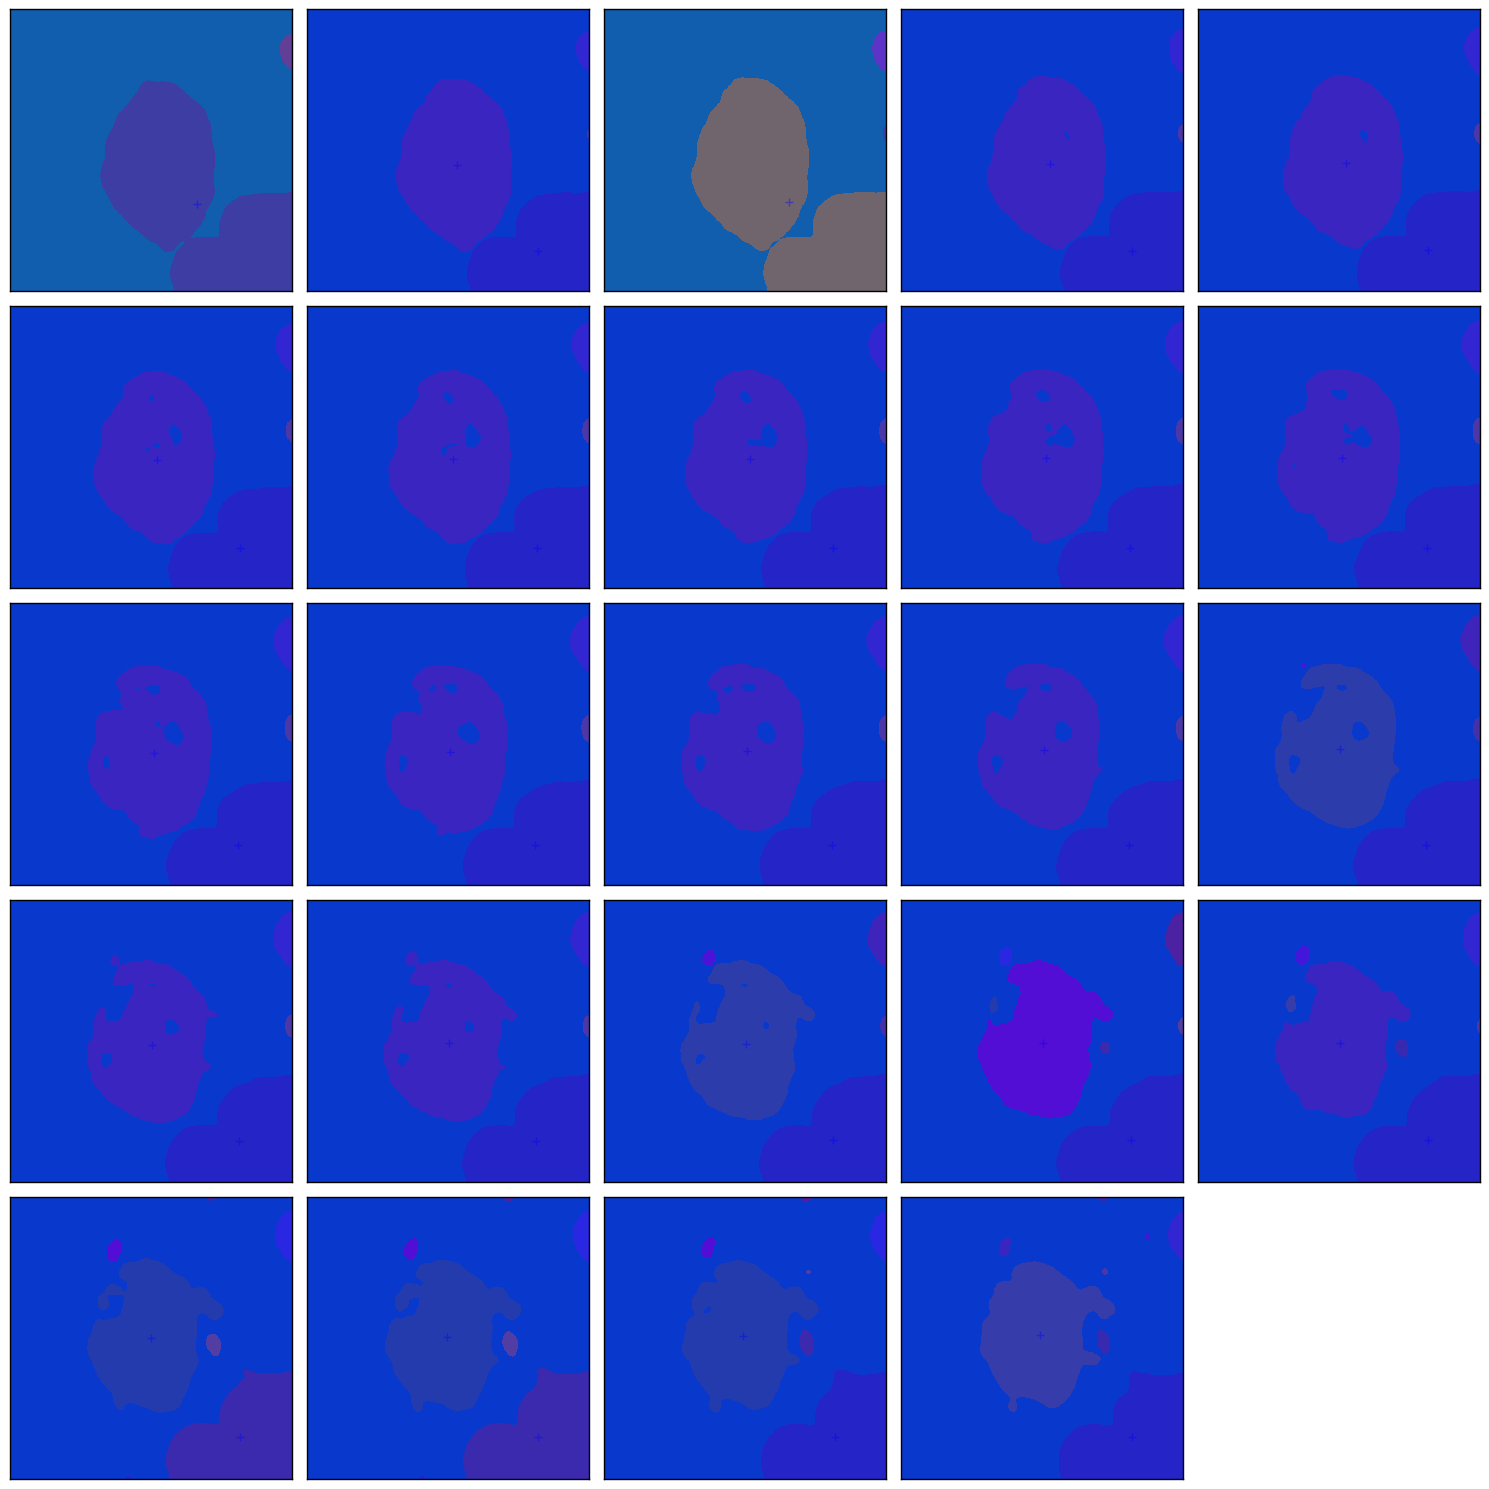

In [55]:
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

for z in range(z_size):
    plane_props = properties[properties['z'] == z]
    if not(plane_props.shape[0]) :
        continue
    i = z // ncols
    j = z % ncols
    axes[i, j].imshow(labeled_stack[z, ...],
                      interpolation='nearest', cmap='Dark2')
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    x_lim = axes[i, j].get_xlim()
    y_lim = axes[i, j].get_ylim()    
    
    
    axes[i, j].scatter(plane_props['y'], plane_props['x'],  
                       s=plane_props['I']*200, alpha=0.4)
    axes[i, j].scatter(plane_props['y'], plane_props['x'],
                       s=40, marker='+', alpha=0.4)
    axes[i, j].set_xlim(x_lim)
    axes[i, j].set_ylim(y_lim)    
 

## Remove empty plots 
for ax in axes.ravel():
    if not(len(ax.images)):
        fig.delaxes(ax)

        
fig.tight_layout()

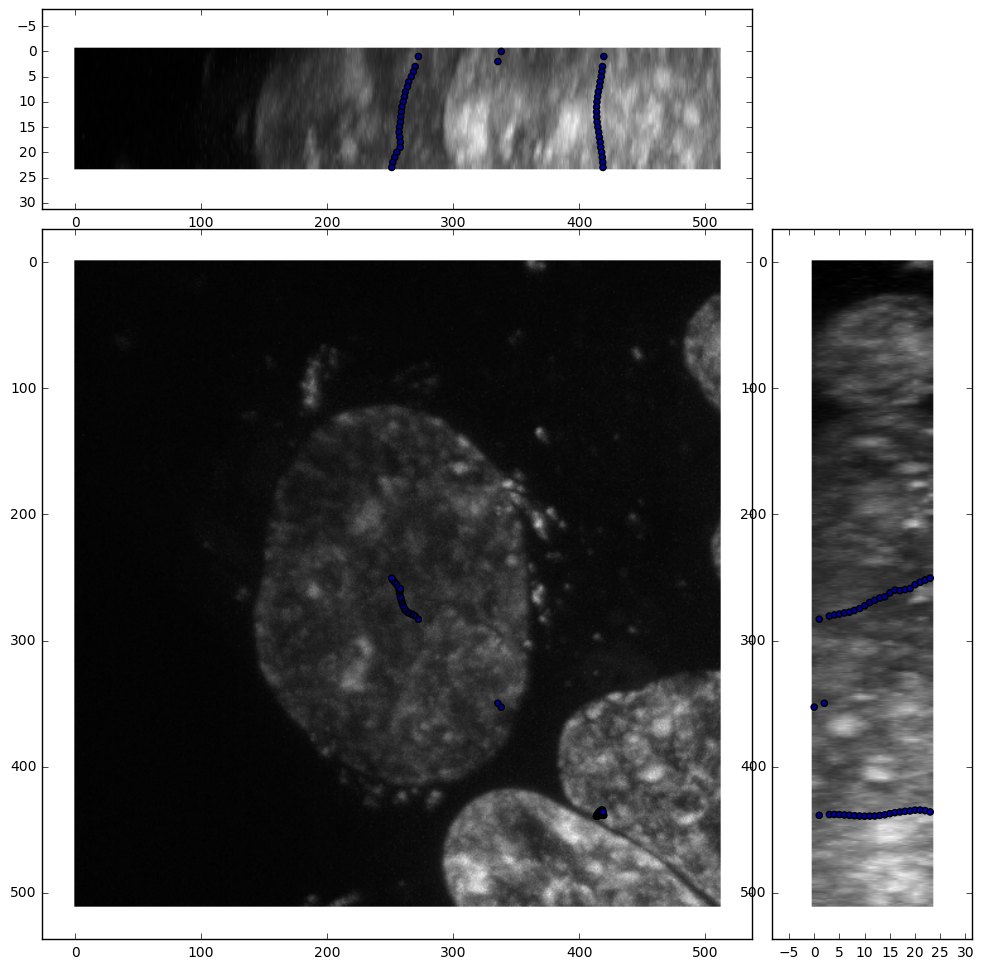

In [56]:
fig = plt.figure(figsize=(12, 12))
colors = plt.cm.jet(properties.index.astype(np.int32))

# xy projection:
ax_xy = fig.add_subplot(111)
ax_xy.imshow(image_stack.max(axis=0), cmap='gray')
ax_xy.scatter(properties['y'],
              properties['x'], c=colors, alpha=1)

divider = make_axes_locatable(ax_xy)
ax_zx = divider.append_axes("top", 2, pad=0.2, sharex=ax_xy)
ax_zx.imshow(image_stack.max(axis=1), aspect=z_scale/xy_scale, cmap='gray')
ax_zx.scatter(properties['y'],
              properties['z'], c=colors, alpha=1)
ax_yz = divider.append_axes("right", 2, pad=0.2, sharey=ax_xy)
ax_yz.imshow(image_stack.max(axis=2).T, aspect=xy_scale/z_scale, cmap='gray')
ax_yz.scatter(properties['z'],
              properties['x'], c=colors, alpha=1)
plt.draw()